# Fake news detection

Models for comparison: BERT with classification layer vs. BERT with BN, hidden fc and classification layers. 

Test hyperparameters: number of epoches, floating-point precicion, resulting embedding

In [1]:
import re
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def extract_data(filepath, info_dict):
    with open(filepath) as f:
        lines = f.readlines()
        for line in lines:
            if re.match('Epoch.*', line):
                info_dict['Accuracy'].append(float(line.split()[9]))
                info_dict['Time'].append(float(line.split()[4]))
    return info_dict

def print_data(info_dict):
    print(f"Accuracy: {info_dict['Accuracy']}, length = {len(info_dict['Accuracy'])}")
    print(f"Time: {info_dict['Time']}, length = {len(info_dict['Time'])}")

In [3]:
classbert_fp16_25_32_1  = {'Accuracy': [], 'Time': []}
classbert_fp16_25_32_4  = {'Accuracy': [], 'Time': []}
deepbert_fp16_25_32_1   = {'Accuracy': [], 'Time': []}
classbert_fp16_100_32_1 = {'Accuracy': [], 'Time': []}
deepbert_fp16_25_32_4   = {'Accuracy': [], 'Time': []}
classbert_fp32_50_64_4  = {'Accuracy': [], 'Time': []}
classbert_fp16_50_64_6  = {'Accuracy': [], 'Time': []}
classbert_fp16_100_32_4 = {'Accuracy': [], 'Time': []}

classbert_fp16_25_32_1  = extract_data('logs/first_train/half_classbert_25_32batch_1.log',
                                       classbert_fp16_25_32_1)
classbert_fp16_25_32_4  = extract_data('logs/first_train/half_classbert_25_32batch_4.log',
                                       classbert_fp16_25_32_4)
deepbert_fp16_25_32_1   = extract_data('logs/first_train/half_deepbert_25_32batch_1.log',
                                       deepbert_fp16_25_32_1)
deepbert_fp16_25_32_4   = extract_data('logs/first_train/half_deepbert_25_32batch_4.log',
                                       deepbert_fp16_25_32_4)
classbert_fp32_50_64_4  = extract_data('logs/23rd_march_train/float_classbert_50_64batch_4.log',
                                       classbert_fp32_50_64_4)
classbert_fp16_50_64_6  = extract_data('logs/23rd_march_train/half_classbert_50_64batch_6.log',
                                       classbert_fp16_50_64_6)
classbert_fp16_100_32_1 = extract_data('logs/20th_train/half_classbert_100_32batch_1.log',
                                       classbert_fp16_100_32_1)
classbert_fp16_100_32_4 = extract_data('logs/20th_train/half_classbert_100_32batch_4.log',
                                       classbert_fp16_100_32_4)

In [5]:
def download_model():
    if not os.path.isfile('models/best_models.zip'):
        os.system('mkdir models/')
        os.chdir('models/')
        os.system('gdown https://drive.google.com/uc?id=1rUE1Pg3nlxaF5dLBU6OP3k2vqsZX9zcN')
        os.system('unzip best_models.zip')
        os.chdir('../../')

Text(0.5, 1.0, 'Classbert_fp16_100_epocs_laststages_4')

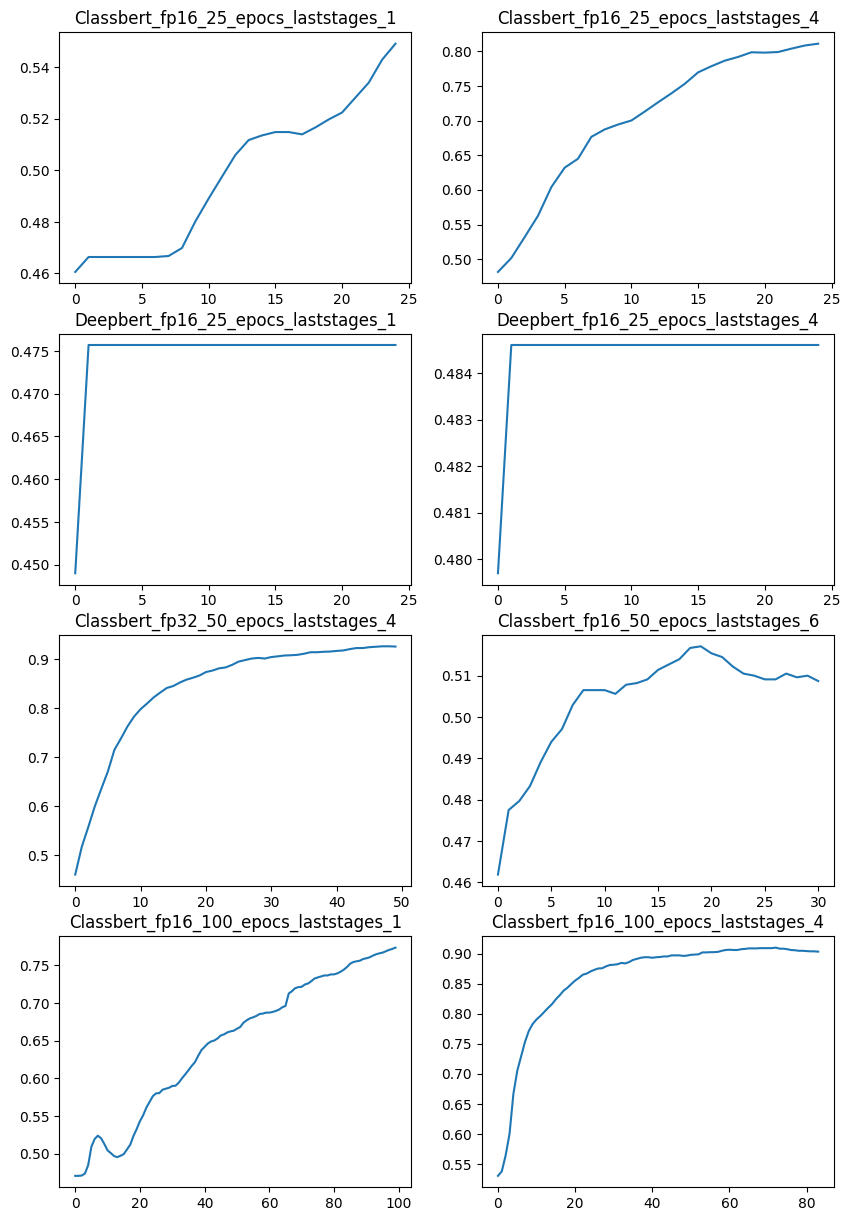

In [7]:
fig, axs = plt.subplots(4, 2, figsize=(10,15))
axs[0, 0].plot(classbert_fp16_25_32_1['Accuracy'])
axs[0, 0].set_title('Classbert_fp16_25_epocs_laststages_1')
axs[0, 1].plot(classbert_fp16_25_32_4['Accuracy'])
axs[0, 1].set_title('Classbert_fp16_25_epocs_laststages_4')
axs[1, 0].plot(deepbert_fp16_25_32_1['Accuracy'])
axs[1, 0].set_title('Deepbert_fp16_25_epocs_laststages_1')
axs[1, 1].plot(deepbert_fp16_25_32_4['Accuracy'])
axs[1, 1].set_title('Deepbert_fp16_25_epocs_laststages_4')
axs[2, 0].plot(classbert_fp32_50_64_4['Accuracy'])
axs[2, 0].set_title('Classbert_fp32_50_epocs_laststages_4')
axs[2, 1].plot(classbert_fp16_50_64_6['Accuracy'])
axs[2, 1].set_title('Classbert_fp16_50_epocs_laststages_6')
axs[3, 0].plot(classbert_fp16_100_32_1['Accuracy'])
axs[3, 0].set_title('Classbert_fp16_100_epocs_laststages_1')
axs[3, 1].plot(classbert_fp16_100_32_4['Accuracy'])
axs[3, 1].set_title('Classbert_fp16_100_epocs_laststages_4')

Хорошо видно, что DeepBERT достаточно плохо справилась с данной задачей и при обучении достигла "потолка" в 0,48, поэтому было принято решение использовать вторую модель.

По первым двум графикам заметно, что тест с суммированием последних 4 слоев дал лучший результат. А увеличение эпох при отсутствии суммирования практически не повлияло на точность (последняя строка, левый столбец).

Мы провели еще один тест с увеличенным количеством эпох и суммируемых слоев (третья строка) однако точность сильно упала, из-за чего логично предположить, что последующее увеличение количества слоев только ухудшило бы результат и 4 - оптимальное значение.

Кроме того, мы пробовали изменить значение точности вычислений с 16 на 32 знака после запятой, но это не дало практически никакого прироста в точности (в первом случае - 0,91 во втором - 0,92), однако сильно повлияло на время и при fp32 модель обучалась примерно в полтора раза дольше.

Таким образом получилось, что Classic BERT обученная 100 эпох при точности вычислений fp32 и суммировании последних 4 слоев (последняя строка, правый столбец) дала наиболее оптимальный результат в 91% точности.